<a href="https://colab.research.google.com/github/IA-DAMA/NeuralNetwork/blob/main/Cnn_0_or_1_Hotdog_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_datasets as tfds

**Tensorflow has our dataset for the following studies**

In [3]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete8TKARV/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete8TKARV/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [4]:
train_ds, valid_ds = ds["train"], ds["validation"]

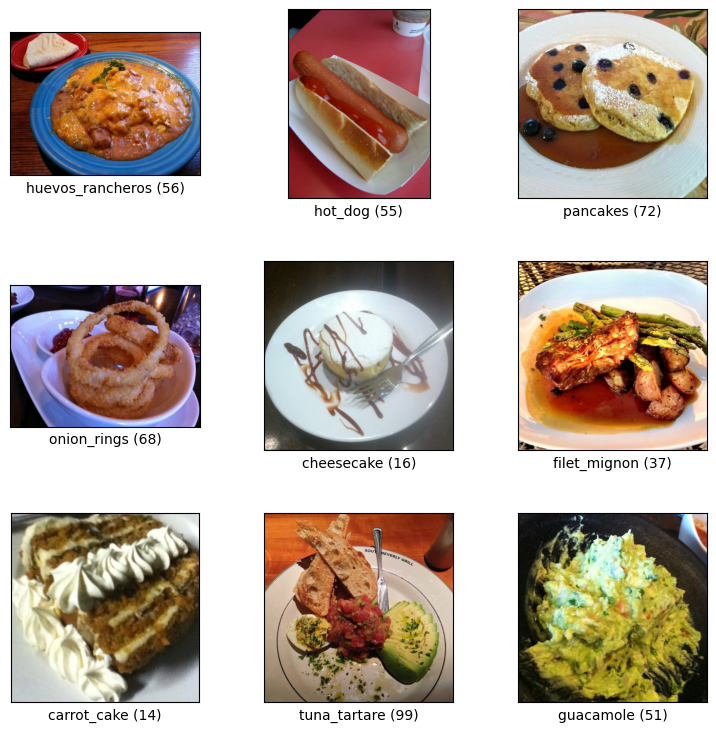

In [5]:
fig = tfds.show_examples(train_ds, ds_info)

*Label for a dog is 55 (You should run it a couple of times til a hot dog comes out)*

In [6]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32),
                          tf.cast(label == HOT_DOG_CLASS, tf.int32))
)

valid_ds = valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32),
                          tf.cast(label == HOT_DOG_CLASS, tf.int32))
)

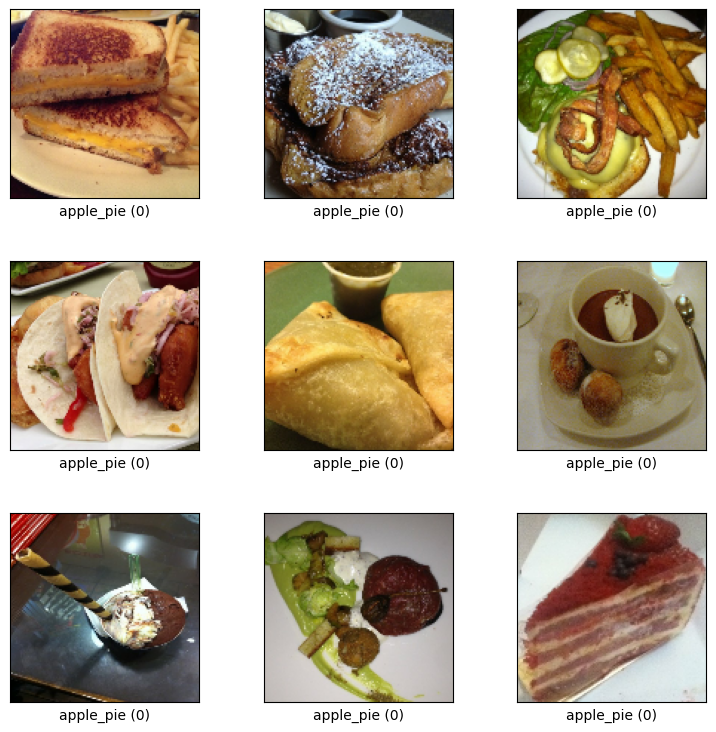

In [7]:
fig = tfds.show_examples(train_ds, ds_info)

*- You'll find ou later it's baby_back_ribs = "hotdogs"*

*- For train and validation, we'll be running the same as you may notice bellow*

*-  To out sample this by repeating 3 times, we take that 750 and duplicate a few times to construct a new dataset*

In [8]:
train_hd_size, valid_hd_size = 750, 250
train_hotdogs = train_ds.filter(lambda _, label: label == 1).repeat(3)
train_nothotdogs = train_ds.filter(lambda _, label: label == 0)

In [9]:
valid_hotdogs = valid_ds.filter(lambda _, label: label == 1).repeat(3)
valid_nothotdogs = valid_ds.filter(lambda _, label: label == 0)

*-   "Cache", which means it'll save some operations from being executed at the beginning of every each cycle it's learning.*

*-   "Batch" because training every single img, it's going to use only batch = 16*

*-   "Prefetch" saves times, cuz it ovelaps the time the preprocessing of data is taking place and model execution of trainig steps, basically, the pipeline is actually already reading data for the next step.*

In [10]:
batch_size = 16

train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_nothotdogs],
                                                [0.5, 0.5], # Weights = 50% each, both hotdogs, nothodogs
                                                stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs],
                                                [0.5, 0.5],
                                                stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

*So to check whether data is the format we want:*

In [11]:
for image_batch, label_batch in train_ds.take(1):
  print(image_batch)
  print(label_batch)

tf.Tensor(
[[[[ 93  34  40]
   [ 94  35  41]
   [ 93  34  40]
   ...
   [ 59  17  27]
   [ 55  15  24]
   [ 52  14  23]]

  [[ 92  34  41]
   [ 91  33  40]
   [ 93  35  42]
   ...
   [ 55  13  23]
   [ 54  14  23]
   [ 55  15  24]]

  [[ 90  33  40]
   [ 91  34  41]
   [ 90  33  40]
   ...
   [ 55  15  24]
   [ 56  14  24]
   [ 55  13  23]]

  ...

  [[106  29  47]
   [101  24  42]
   [105  28  46]
   ...
   [126  42  57]
   [128  44  60]
   [119  36  53]]

  [[108  31  49]
   [106  29  47]
   [102  25  43]
   ...
   [128  44  60]
   [124  40  58]
   [116  33  51]]

  [[106  29  47]
   [110  33  51]
   [108  31  49]
   ...
   [121  36  53]
   [124  40  59]
   [121  38  58]]]


 [[[ 44  35  30]
   [ 47  37  32]
   [ 44  33  29]
   ...
   [ 84  66  57]
   [ 71  61  53]
   [ 47  45  36]]

  [[ 42  33  28]
   [ 45  35  31]
   [ 49  38  34]
   ...
   [ 89  79  71]
   [ 58  51  44]
   [ 50  45  39]]

  [[ 48  39  34]
   [ 47  37  32]
   [ 49  38  34]
   ...
   [ 75  70  65]
   [ 47  43  38]


#Neural Net Implementation



    *   Models are sequential
    *   Rescaling is setting values between 0 and 1
    *   Conv2D(number_of_filters, size across img by img, 'relu', input_shape)
    *   MaxPooling2D(2, 2) because that's pretty standard
    *   Dense is actually ensuring each input to go to every single node
    *   So output layer - Dense(1) because it's binary, so 0s and 1s to calissify whther is a hotdog or not

    *   Dropout'll turn off 25% of of the connections


**Building up our model**

In [12]:
#tf.random.set_seed(0)

In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

In [24]:
for i,_ in ds["train"].take(1):
  image = i

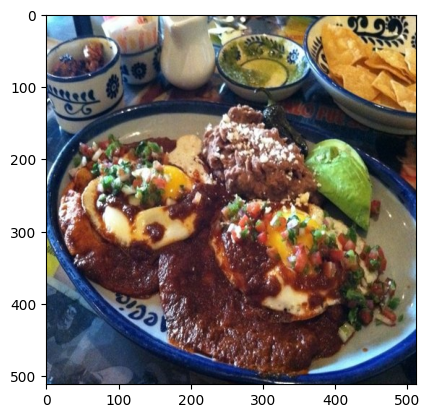

In [25]:
plt.imshow(image)

In [26]:
image = tf.cast(tf.expand_dims(image, 0), tf.float32)
image /= 255.0

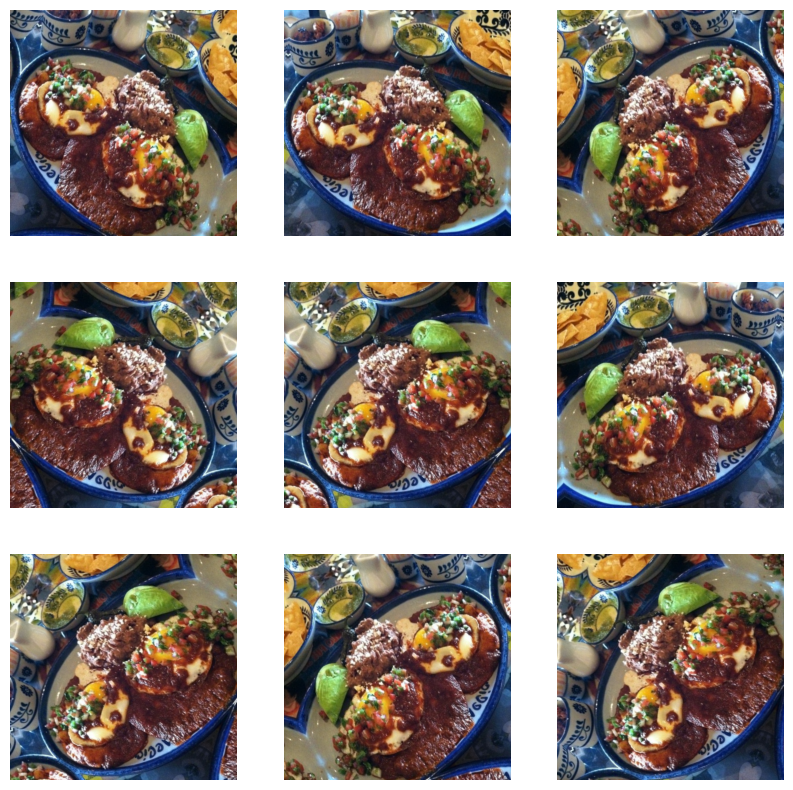

In [27]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [28]:
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(data_augmentation) #
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=[MAX_SIDE_LEN, MAX_SIDE_LEN, 3]))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))


**Model.compile**

In [29]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

*Now model is compiled*

**Model.fit**

In [30]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/50
278/278 [==============================] - 897s 3s/step - loss: 1.4407 - accuracy: 0.4964 - val_loss: 1.1898 - val_accuracy: 0.5076
Epoch 2/50
278/278 [==============================] - 292s 1s/step - loss: 1.0464 - accuracy: 0.5074 - val_loss: 0.9326 - val_accuracy: 0.5128
Epoch 3/50
278/278 [==============================] - 284s 1s/step - loss: 0.8774 - accuracy: 0.5325 - val_loss: 0.8267 - val_accuracy: 0.5181
Epoch 4/50
278/278 [==============================] - 289s 1s/step - loss: 0.7991 - accuracy: 0.5455 - val_loss: 0.7687 - val_accuracy: 0.5607
Epoch 5/50
278/278 [==============================] - 286s 1s/step - loss: 0.7583 - accuracy: 0.5541 - val_loss: 0.7327 - val_accuracy: 0.5699
Epoch 6/50
278/278 [==============================] - 304s 1s/step - loss: 0.7319 - accuracy: 0.5552 - val_loss: 0.7081 - val_accuracy: 0.5890
Epoch 7/50
278/278 [==============================] - 292s 1s/step - loss: 0.7104 - accuracy: 0.5778 - val_loss: 0.6934 - val_accuracy: 0.5778

In [62]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in valid_ds.take(1):
  images = image_batch
  labels = label_batch

<Figure size 1000x1000 with 0 Axes>

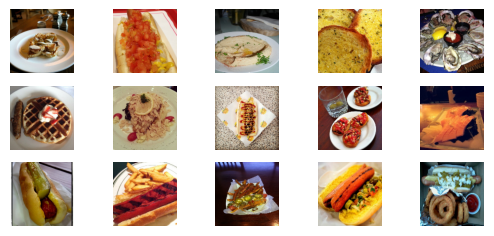

In [65]:
for i in range(15):
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(images[i])
  plt.axis('off')

In [66]:
labels[:15]

<tf.Tensor: shape=(15,), dtype=int32, numpy=array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1], dtype=int32)>